# QiTech Thermostat Controller Challenge
## Scenario
We have a high-mass element A of which we can measure the temperature of.

We have a low-mass element B which we can heat. Both Elements are in contact to each other. Element B can also discapate heat to the environment.

## Goal
Create an algorithm that control the power of the heating element. Your controller have persitent values and a function `control` which takes the measures temperature of element A, the target temperature (constant) and the constant ambient temperature. `dt` is the time delta in seconds (always `1`). 
Only control signal from `0`-`1` have effect. `1` means maximum heating power.

Its your goal to build a generalistic thermostat controller (as we don't know the exact properties ofour real system) that improves core metrics.

## Simulation
We have a simple simulatoin called `TemperatureSimulation` with standard properties that don't change. `SuperTemperatureSimulation` runs many simulations with different properties so we can see how your controller behaves in different situations.

## Metrics
### Mean Error
Mean error calculated after 1800 seconds.
The error is the target temp - measured temp in C.

This tracks the steady state error fo your controller and should be near 0.

## Error STD
Standard deviation (sigma) of the error after 1800 seconds.

This tracks the temperature oscillation and should be near 0.

## Overshoot
The maxmumum overshoot the system produced. Overshoot is the maxmimum measured temperature - target temperature.

overshoot should be minimal.

## Time to reach ±0.5°C
This metric tracks the time your controller needs to reach a stable temperature in seconds.

This metric should also be minimized.

Running single simulation with default parameters...
Simulation Parameters:
Element A (measured element):
- Mass: 1.0 kg
- Specific Heat Capacity: 490 J/(kg·°C)

Element B (heating element):
- Mass: 0.4 kg
- Specific Heat Capacity: 400 J/(kg·°C)

Heat Transfer:
- A-B Contact Area: 0.5 m²
- A-B Heat Transfer Coefficient: 100 W/(m²·°C)
- B-Air Contact Area: 0.5 m²
- B-Air Heat Transfer Coefficient: 10 W/(m²·°C)

Environment:
- Ambient Temperature: 25 °C

Simulation Settings:
- Total Time: 3600 seconds
- Time Step (dt): 1 seconds
Simulation Statistics:
- Mean Error (after 1800s): -43.25 °C
- Error STD (after 1800s): 1.56 °C
- Overshoot Error: 45.55 °C
- Final Element A Temperature: 192.17 °C
- Final Element B Temperature: 190.49 °C
- Maximum A-B Temperature Difference: 10.06 °C
- Time to reach ±0.5°C: inf seconds


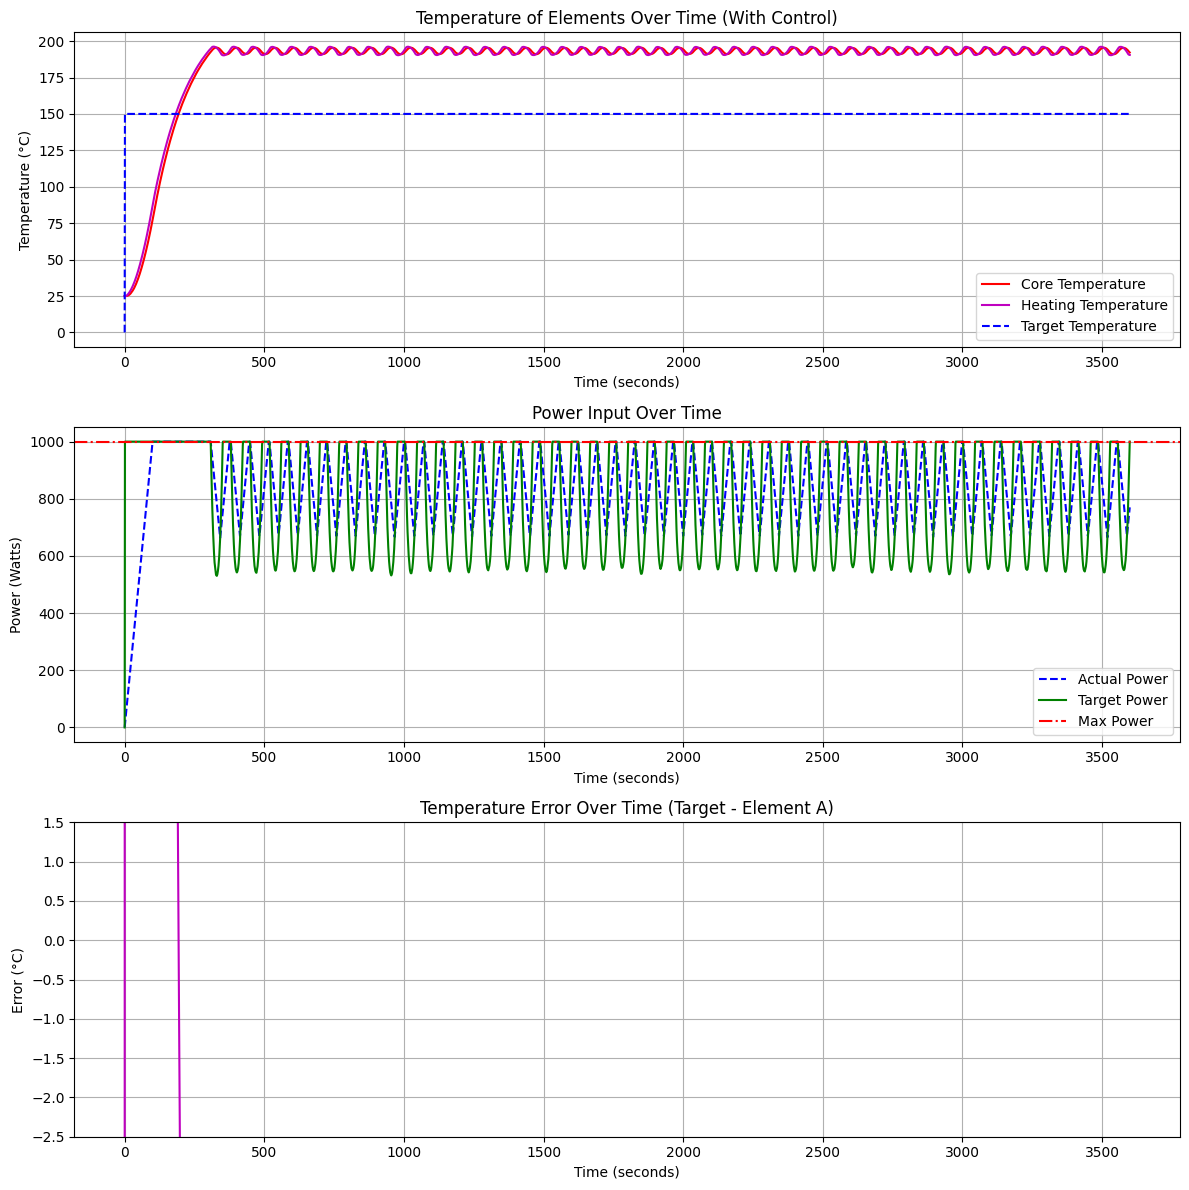

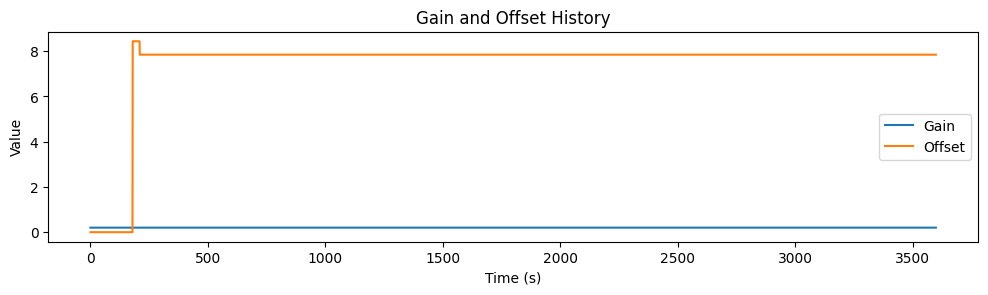

In [1]:
import tempsim

gain_history = []
offset_history = []
time = []

def compute_gain_cost(errors):
    """Compute the standard deviation of a list of errors."""
    mean_error = sum(errors) / len(errors)
    return (sum((e - mean_error) ** 2 for e in errors) / len(errors)) ** 0.5

def compute_gradient_gain(errors, gain, offset, target_temp, delta=1e-3):
    """
    Estimate the gradient of the gain cost (std error) with respect to gain using finite differences.
    """
    e = 2.718281828459045
    gain_up = gain + delta
    # Simulate control signal with increased gain
    signal_up = [compute_signal(err, gain_up, offset, e) for err in errors]
    # Estimate new errors if gain is increased
    error_up = [target_temp - (target_temp - err + (sig - 0.5)) for err, sig in zip(errors, signal_up)]
    gain_cost = compute_gain_cost(errors)
    gain_cost_up = compute_gain_cost(error_up)
    grad = (gain_cost_up - gain_cost) / delta
    return grad

def compute_offset_cost(errors):
    """Compute the mean of a list of errors."""
    return sum(errors) / len(errors)

def compute_gradient_offset(errors, gain, offset, target_temp, delta=1e-3):
    """
    Estimate the gradient of the offset cost (mean error) with respect to offset using finite differences.
    """
    e = 2.718281828459045
    offset_up = offset + delta
    # Simulate control signal with increased offset
    signal_up = [compute_signal(err, gain, offset_up, e) for err in errors]
    # Estimate new errors if offset is increased
    error_up = [target_temp - (target_temp - err + (sig - 0.5)) for err, sig in zip(errors, signal_up)]
    offset_cost = compute_offset_cost(errors)
    offset_cost_up = compute_offset_cost(error_up)
    grad = (offset_cost_up - offset_cost) / delta
    return grad

def compute_signal(error, gain, offset, e=2.718281828459045):
    """Compute the control signal (sigmoid)."""
    return 1 / (1 + e ** (-gain * (error + offset))) * 1000

def create_controller():
    """
    Create a controller function with adaptive gain and offset using gradient descent.
    """
    gain = 0.2
    offset = 0.0
    e = 2.718281828459045
    error_history = []
    learning_rate_offset = 5e-3
    learning_rate_gain = 0  # Set to nonzero to enable gain learning

    def control(measured_temp, target_temp, ambient_temperature, dt):
        nonlocal error_history, offset, gain

        # Calculate error and update history
        error = target_temp - measured_temp
        error_history.append(error)

        if len(error_history) > 30:
            error_history.pop(0)

        # has reached learning cycle
        do_learning = len(error_history) == 30 and (len(time) % 30 == 0)
        is_steady = abs(error) <= 10

        # Offset learning: use gradient descent on mean error
        if do_learning and is_steady:
            # Calculate the current mean error
            mean_error = compute_offset_cost(error_history)

            # We want to minimize the absolute mean error, not just decrease it
            # If mean error is positive, we need to increase offset
            # If mean error is negative, we need to decrease offset
            offset_change = (
                learning_rate_offset * mean_error * 100
            )  # Direct adjustment based on error

            offset += offset_change

            # Clamp offset to a reasonable range
            offset = max(-10.0, min(offset, 10.0))

        # Gain learning: use gradient descent to minimize std of error
        if do_learning:
            grad = compute_gradient_gain(error_history, gain, offset, target_temp)
            gain -= learning_rate_gain * grad
            gain = max(0.0, min(gain, 10))

        # Compute control signal (sigmoid)
        signal = compute_signal(error, gain, offset, e)

        # Log gain, offset, and time for analysis
        gain_history.append(gain)
        offset_history.append(offset)
        time.append(time[-1] + dt if time else 0)

        return signal

    return control


# Create controller
pid_controller = create_controller()

# Run a single simulation first to see baseline performance
print("Running single simulation with default parameters...")
sim = tempsim.TemperatureSimulation(pid_controller)
sim.run_simulation()
sim.print_parameters()
sim.print_statistics()
sim.plot_results()


# plot gain and offset history
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, gain_history, label='Gain')
plt.plot(time, offset_history, label='Offset')
plt.title('Gain and Offset History')
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.legend()
plt.show()


Running multiple randomized simulations...
Running simulation 100/100...
===== AGGREGATE SIMULATION STATISTICS =====
Based on 100 randomized simulations

Mean Error (after 1800s):
  Mean: -45.23 °C
  Std Dev: 5.67 °C

Error Standard Deviation (after 1800s):
  Mean: 0.08 °C
  Std Dev: 0.36 °C

Overshoot Error:
  Mean: 53.62 °C
  Std Dev: 10.43 °C

Max Temperature Difference between Elements A and B:
  Mean: 19.30 °C
  Std Dev: 5.72 °C

Time to reach ±0.5°C for 600s:
  Never achieved in any simulation


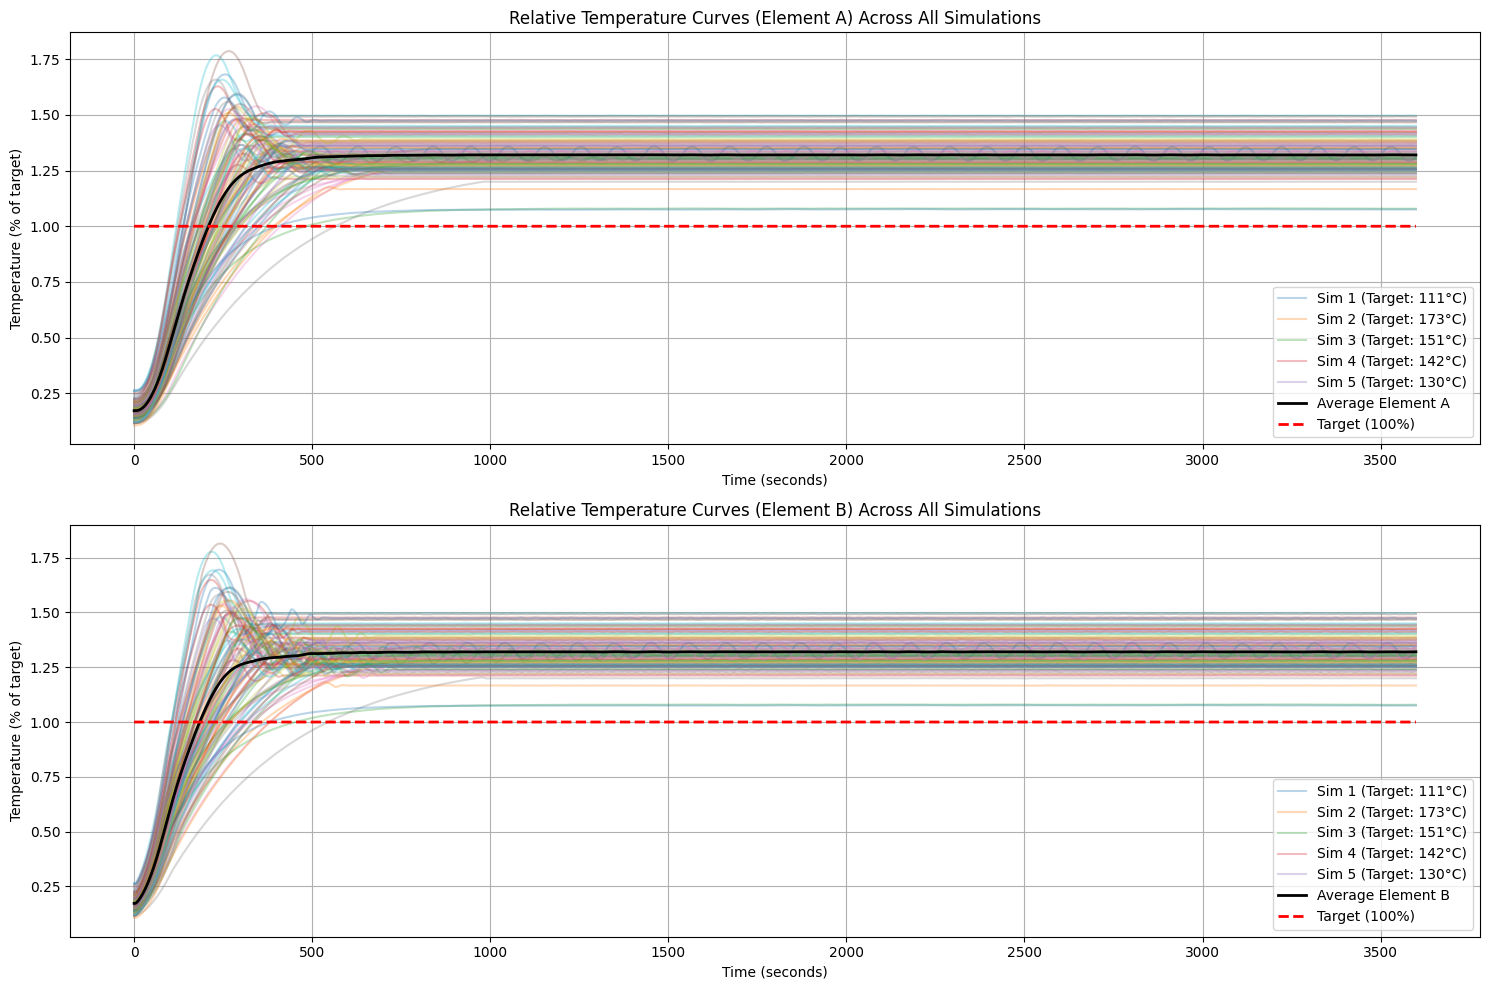

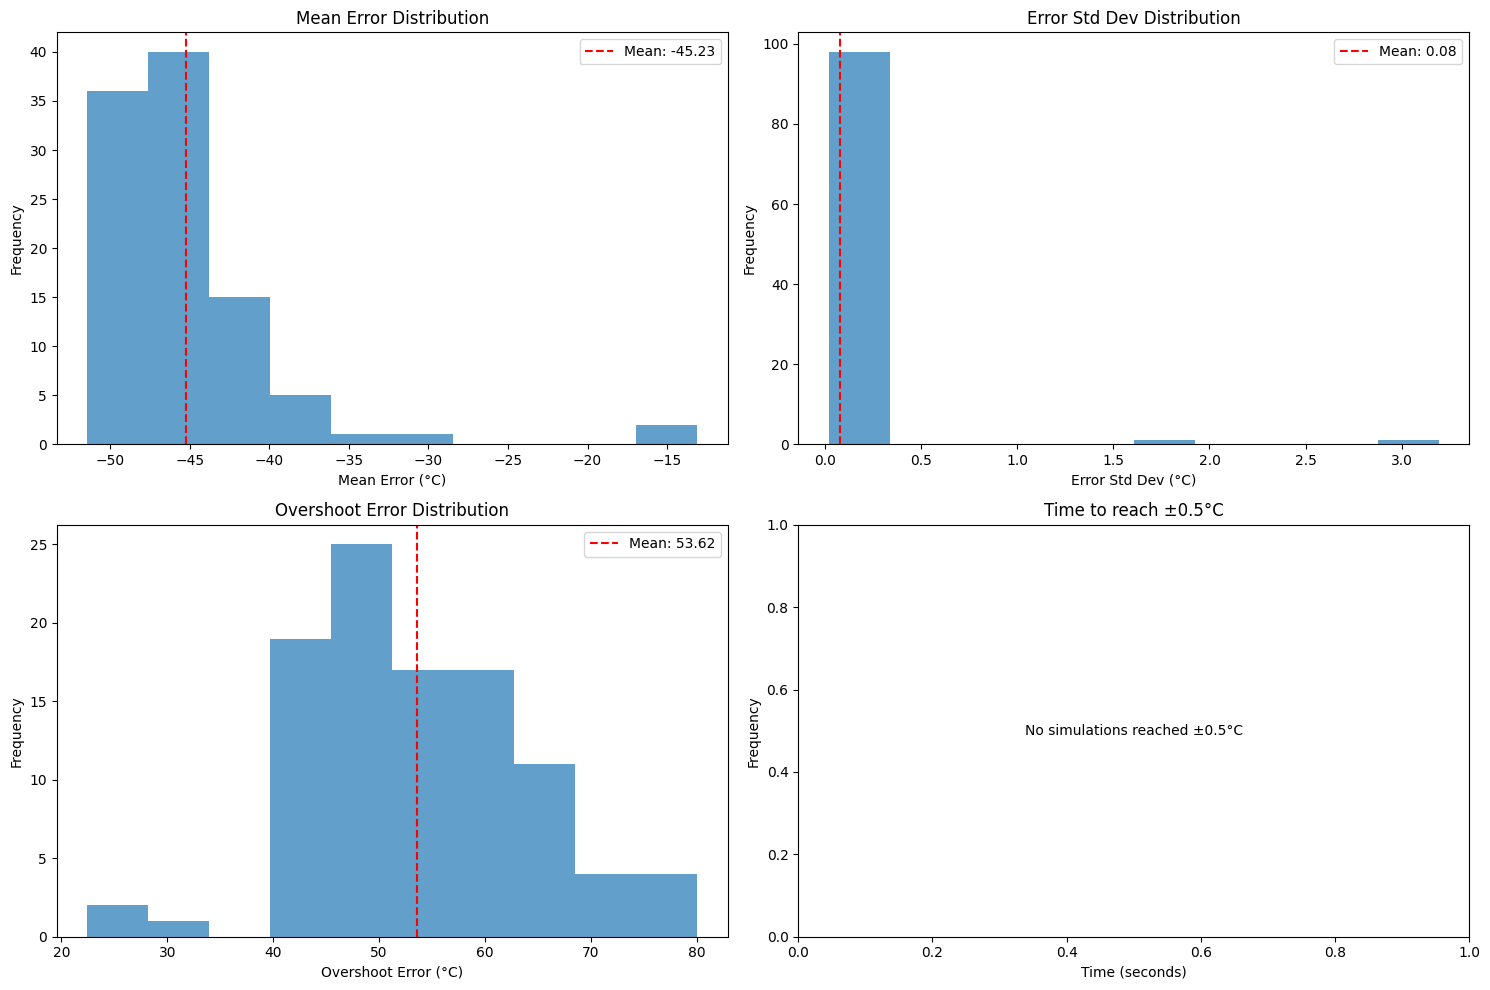

In [2]:
# Run multiple randomized simulations
print("\nRunning multiple randomized simulations...")
super_sim = tempsim.SuperTemperatureSimulation(
    control_function=pid_controller,
    n_simulations=100,
)

# Run all simulations
super_sim.run_simulations()

# Print aggregate statistics
super_sim.print_aggregate_statistics()

# Visualize results
super_sim.plot_temperature_comparison()
super_sim.plot_error_distribution()